# 08 Capital Asset Pricing Model - Implementation
## Import Python Modules

In [1]:
from dataclasses import dataclass, field
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Lecture 1 - Creating CAPM Class

Stock Prices:
* _Closing Price_ of a stock of the actual price the close of the trading day
* _Adjusted Closing Price_ takes into account factors such as dividends, stock splits, etc. (more accurate reflection of stock's value)

In [2]:
@dataclass
class CAPM:
    start_date: str
    end_date: str
    stocks: list[str] = field(default_factory=list)
    data: pd.DataFrame = None

    def download_data(self):
        data = {}
        for stock in self.stocks:
            ticker = yf.download(stock, self.start_date, self.end_date)
            data[stock] = ticker["Adj Close"]
        # resample to monthly data at end of month
        self.data = pd.DataFrame(data)

    def prepare_data(self):
        # resample to monthly returns instead of daily returns
        stock_data = self.data.resample('M').last()

        self.data = pd.DataFrame({'s_adjclose': stock_data[self.stocks[0]],
                                  'm_adjclose': stock_data[self.stocks[1]]})

        # logarithmic monthly returns = r_[t-1] / r_[t]
        self.data[['s_returns', 'm_returns']] = np.log(self.data[['s_adjclose', 'm_adjclose']] /
                                                       self.data[['s_adjclose', 'm_adjclose']].shift(1))

        # remove the NaN values
        self.data = self.data[1:]

    def calculate_beta(self):
        # covariance matrix: diagonal are the variances
        # off diagonal values are covariances
        covariance_matrix = np.cov(self.data["s_returns"], self.data["m_returns"])
        # beta = cov(r_a, r_m) / var(r_m)
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
        return beta

In [3]:
stocks = ["IBM", "^GSPC"] # ^GSPC is the S&P500 index 
start_date = "2009-12-01"
end_date = "2017-01-01"

capm = CAPM(start_date, end_date, stocks)
capm.download_data()
capm.data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,IBM,^GSPC
Date,,
2009-12-01,76.549034,1108.859985
2009-12-02,76.112267,1109.239990
2009-12-03,76.315689,1099.920044
2009-12-04,76.136192,1105.979980
2009-12-07,76.010536,1103.250000


## Lecture 2 - Compute Covariance and Beta 
Frequency of Time Series Data
* market data can have very high frequencies depending on the traded asset
* daily stock returns can take into account holidays and are good for short-term forecasting
* monthly stock returns are approximately normally distributed and better for long-term models
* most traditional statistical models like linear regression assume normally distributed data

In [4]:
capm.prepare_data()
capm.data.head()

,s_adjclose,m_adjclose,s_returns,m_returns
Date,,,,
2010-01-31,73.228371,1073.869995,-0.067221,-0.037675
2010-02-28,76.422653,1104.489990,0.042696,0.028115
2010-03-31,77.077690,1169.430054,0.008535,0.057133
2010-04-30,77.528465,1186.689941,0.005831,0.014651
2010-05-31,75.666626,1089.410034,-0.024308,-0.085532


Interpreting Beta
* $\beta = 1$ : stock is moving exactly like the market
* $\beta > 1$ : stock is more volatile than the market  
* $\beta < 1$ : stock is less volatile than the market

In [5]:
beta = capm.calculate_beta()
print(f"Beta for IBM with S&P500 is {beta:.2f}")

Beta for IBM with S&P500 is 0.73


## Lecture 3 - Linear Regression

CAPM Formula rewritten for Linear Regression

$E[r_a] - r_f = \alpha + \beta (E[r_m]-r_f)$

In [6]:
def linear_regression(data, r_f=0.0, month_in_year=12):
    # using linear regression to fit a line to the data
    # [stock_returns, market_returns] - slope is the beta
    beta, alpha = np.polyfit(data['m_returns'], data['s_returns'], deg=1) # deg is order of polynomial
    alpha = alpha if alpha else 0.0
    # calculate the expected return according to the CAPM formula
    # we are after annual return (this is why multiply by 12)
    expected_return = r_f + beta * (data['m_returns'].mean()*month_in_year - r_f)
    return (alpha, beta), expected_return

In [7]:
coeff, expected_return = linear_regression(capm.data)

print(f"Alpha = {coeff[0]:.2f}")
print(f"Beta = {coeff[1]:.2f}")
print(f"Expected Return = {expected_return:.2f}")

Alpha = -0.00
Beta = 0.73
Expected Return = 0.07


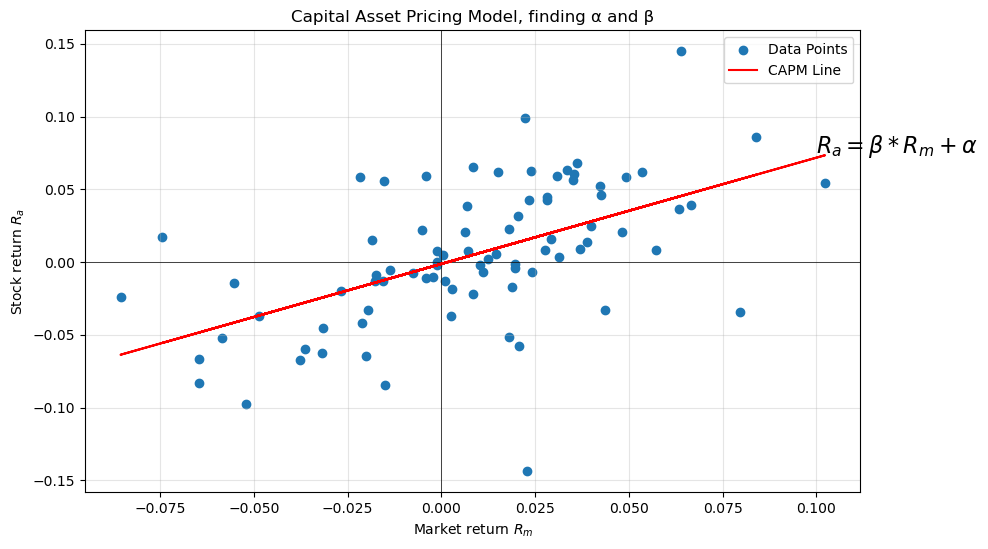

In [8]:
def plot_regression(data, coeff):
    alpha, beta = coeff
    _, ax = plt.subplots(1, figsize=(10, 6))
    ax.axhline(lw=0.5, c="k")
    ax.axvline(lw=0.5, c="k")
    ax.scatter(data["m_returns"], data['s_returns'], label="Data Points")
    ax.plot(data["m_returns"], beta * data["m_returns"] + alpha, color='red', label="CAPM Line")
    plt.title('Capital Asset Pricing Model, finding α and β')
    plt.xlabel('Market return $R_m$')
    plt.ylabel('Stock return $R_a$')
    plt.text(0.1, 0.075, r'$R_a = \beta * R_m + \alpha$', fontsize=16)
    plt.legend()
    plt.grid(alpha=0.33)
    plt.show()

plot_regression(capm.data, coeff)

## Exercise 1 - Normal Distribution
Check if the monthly IBM returns are normally distrbuted

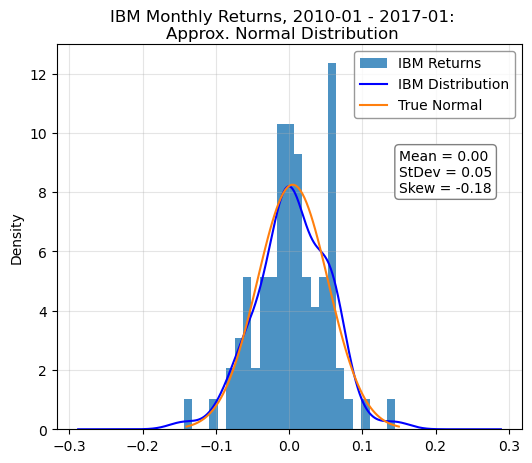

In [9]:
ibm_returns = capm.data["s_returns"]
mu = ibm_returns.mean()
sigma = ibm_returns.std()
skew = ibm_returns.skew()

fig, ax = plt.subplots(1,1, figsize=(6, 5))
fig.suptitle("IBM Monthly Returns, 2010-01 - 2017-01:\nApprox. Normal Distribution", y=0.95)

# plot IBM data
ibm_returns.plot(kind="hist", bins=25, density=True, ax=ax, alpha=0.8, label="IBM Returns")
ibm_returns.plot(kind="kde", ax=ax, color="b", label="IBM Distribution")

# plot true normal distribution
from scipy.stats import norm
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), label="True Normal")

ax.grid(alpha=.33)
props = dict(boxstyle='round', facecolor="white",  edgecolor="gray")
ax.text(0.15, 8, f"Mean = {mu:.2f}\nStDev = {sigma:.2f}\nSkew = {skew:.2f}", bbox=props)
ax.legend(edgecolor="gray");